In [1]:
DATA_PATH = 'C:\\Users\\tomte\\SGDatavers\\football_euro\\'
RANKING_PATH = f'{DATA_PATH}fifa_ranking-2023-07-20.csv'
MATCH_PATH = f'{DATA_PATH}international_matches.csv'
RESULT_PATH = f'{DATA_PATH}results.csv'

In [2]:
import numpy as np
import pandas as pd 
import datetime as dt
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict
import matplotlib.pyplot as plt

### 0) Read Data

In [3]:
ranking_data = pd.read_csv(RANKING_PATH, parse_dates=["rank_date"], index_col="rank_date")
match_data = pd.read_csv(MATCH_PATH)
result_data = pd.read_csv(RESULT_PATH)

In [4]:
ranking_data.head(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
rank_date,,,,,,,
1992-12-31,1,Germany,GER,57.0,0.0,0,UEFA
1992-12-31,96,Syria,SYR,11.0,0.0,0,AFC
1992-12-31,97,Burkina Faso,BFA,11.0,0.0,0,CAF


In [5]:
match_data.head(3)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
result_data.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False


In [7]:
match_data = match_data.replace({'Germany DR': 'Germany', 'China': 'China PR'})
match_data['date'] = pd.to_datetime(match_data['date'])

### 1) Filter Data by Euro

In [8]:
ranking_uefa = ranking_data[ranking_data['confederation'] == 'UEFA']

In [9]:
european_countries: list = list(ranking_uefa['country_full'].unique())

In [10]:
home_team_mask = match_data['home_team_continent'] == 'Europe'
away_team_mask = match_data['away_team_continent'] == 'Europe'

In [11]:
team_masks = np.logical_and.reduce([home_team_mask, away_team_mask])

In [12]:
match_europe = match_data[team_masks] 

In [13]:
match_europe.head(3)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
8,1993-08-11,Faroe Islands,Norway,Europe,Europe,111,9,0,0,0,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1993-08-11,Sweden,Switzerland,Europe,Europe,4,3,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,1993-08-22,Sweden,France,Europe,Europe,4,12,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
home_country_mask = result_data['home_team'].isin(european_countries)
away_country_mask = result_data['away_team'].isin(european_countries)

In [15]:
country_masks = np.logical_and.reduce([home_country_mask, away_country_mask])

In [16]:
result_europe = result_data[country_masks] 

In [17]:
result_europe.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False


In [18]:
result_europe.shape

(13383, 9)

### 3) Webscrapping

In [24]:
#Scraps data from webpage
def get_group_matches():
    url = "https://en.wikipedia.org/wiki/UEFA_Euro_2024"
    html = urlopen(url).read().decode("utf-8")
    soup = BeautifulSoup(html, "html.parser")
    wikitables = soup.find_all("table", class_="fevent")

    group_dict = defaultdict(list)
    g_names = ['A', 'B', 'C', 'D', 'E', 'F']
    counter = 0
    nMATCHES_IN_GROUPS = 6

    for wikitable in wikitables:
        # Check if the current table matches the specified structure
        if wikitable.find("th", class_="fhome", itemprop="homeTeam", text="Runner-up Group A"):
            break  # Break out of the loop if the specified table structure is found

        matches = wikitable.find_all('tr', itemprop="name")

        for match in matches:
            home_team_element = match.find("th", class_="fhome")
            away_team_element = match.find("th", class_="faway")

            if home_team_element and away_team_element:
                home_team_span = home_team_element.find("span", itemprop="name")
                away_team_span = away_team_element.find("span", itemprop="name")

                if home_team_span and away_team_span:
                    home_team = home_team_span.text.strip()
                    away_team = away_team_span.text.strip()

                    # Update counter if the current group reaches the max number of matches
                    if len(group_dict[g_names[counter]]) == nMATCHES_IN_GROUPS:
                        counter += 1
                        # Check if counter exceeds the length of group names list
                        if counter >= len(g_names):
                            break  

                    group_dict[g_names[counter]].append((home_team, away_team))

    return dict(group_dict)

# Converts scrapped data into dataframe
def create_group_df():
    rows = []
    group_dict = get_group_matches()
    for groups, matches in group_dict.items():
        for home,away in matches:
            rows.append([groups, home, away, 0, 0])
    game_results_df = pd.DataFrame(rows, columns=['Group', 'HomeTeam', 'AwayTeam', 'tot_group_points_Home', 'tot_group_points_Away'])
    return game_results_df

In [19]:
eu_groups = pd.read_csv('europe_groups.csv')

In [20]:
eu_groups.head()

,Group,HomeTeam,AwayTeam,tot_group_points_Home,tot_group_points_Away
0,A,Germany,Scotland,0,0
1,A,Hungary,Switzerland,0,0
2,A,Germany,Hungary,0,0
3,A,Scotland,Switzerland,0,0
4,A,Switzerland,Germany,0,0


In [21]:
ranking_data = ranking_uefa.groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

C:\Users\tomte\AppData\Local\Temp\ipykernel_4536\3292240289.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ranking_data = ranking_uefa.groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()


In [22]:
ranking_data

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,1992-12-31,86.0,Albania,ALB,14.0,0.0,0.0,UEFA
1,1993-01-01,86.0,Albania,ALB,14.0,0.0,0.0,UEFA
2,1993-01-02,86.0,Albania,ALB,14.0,0.0,0.0,UEFA
3,1993-01-03,86.0,Albania,ALB,14.0,0.0,0.0,UEFA
4,1993-01-04,86.0,Albania,ALB,14.0,0.0,0.0,UEFA
...,...,...,...,...,...,...,...,...
586806,2002-11-16,16.0,Yugoslavia,YUG,690.0,672.0,-4.0,UEFA
586807,2002-11-17,16.0,Yugoslavia,YUG,690.0,672.0,-4.0,UEFA
586808,2002-11-18,16.0,Yugoslavia,YUG,690.0,672.0,-4.0,UEFA
586809,2002-11-19,16.0,Yugoslavia,YUG,690.0,672.0,-4.0,UEFA


In [23]:
match_data = match_europe.merge(ranking_data,
                        left_on=['date', 'home_team'],
                        right_on=['rank_date', 'country_full'])
match_data = match_data.merge(ranking_data,
                        left_on=['date', 'away_team'],
                        right_on=['rank_date', 'country_full'],
                        suffixes=('_home', '_away'))

In [24]:
match_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,rank_change_home,confederation_home,rank_date_away,rank_away,country_full_away,country_abrv_away,total_points_away,previous_points_away,rank_change_away,confederation_away
0,1993-08-11,Faroe Islands,Norway,Europe,Europe,111,9,0,0,0,...,17.0,UEFA,1993-08-11,9.0,Norway,NOR,54.0,49.0,-5.0,UEFA
1,1993-08-11,Sweden,Switzerland,Europe,Europe,4,3,0,0,1,...,0.0,UEFA,1993-08-11,3.0,Switzerland,SUI,57.0,51.0,-9.0,UEFA
2,1993-08-22,Sweden,France,Europe,Europe,4,12,0,0,1,...,0.0,UEFA,1993-08-22,12.0,France,FRA,52.0,46.0,-7.0,UEFA
3,1993-08-25,Austria,Finland,Europe,Europe,38,47,0,0,3,...,4.0,UEFA,1993-08-25,47.0,Finland,FIN,34.0,31.0,3.0,UEFA
4,1993-08-25,Denmark,Lithuania,Europe,Europe,10,84,0,0,4,...,1.0,UEFA,1993-08-25,84.0,Lithuania,LTU,19.0,12.0,-9.0,UEFA


In [25]:
match_data = match_data.dropna(how="all")

In [26]:
match_data.shape

(6393, 41)

### Feature Engineering

In [27]:
# Convert columns to numerical data types if necessary
match_data['home_team_fifa_rank'] = pd.to_numeric(match_data['home_team_fifa_rank'], errors='coerce')
match_data['away_team_fifa_rank'] = pd.to_numeric(match_data['away_team_fifa_rank'], errors='coerce')
match_data['home_team_total_fifa_points'] = pd.to_numeric(match_data['home_team_total_fifa_points'], errors='coerce')
match_data['away_team_total_fifa_points'] = pd.to_numeric(match_data['away_team_total_fifa_points'], errors='coerce')
match_data['home_team_score'] = pd.to_numeric(match_data['home_team_score'], errors='coerce')
match_data['away_team_score'] = pd.to_numeric(match_data['away_team_score'], errors='coerce')

# Useful variables
match_data['Rank_difference'] = match_data['home_team_fifa_rank'] - match_data['away_team_fifa_rank']
match_data['AVG_difference'] = (match_data['home_team_fifa_rank'] + match_data['away_team_fifa_rank']) / 2
match_data['points_difference'] = match_data['home_team_total_fifa_points'] - match_data['away_team_total_fifa_points']
match_data['score_difference'] = match_data['home_team_score'] - match_data['away_team_score']
match_data['is_won'] = match_data['score_difference'] > 0  # take draw as lost
match_data['is_stake'] = match_data['tournament'] != 'Friendly'

max_rest = 30
match_data['rest_days'] = match_data.groupby('home_team')['date'].diff().dt.days.clip(0, max_rest).fillna(max_rest)

#All countries participating in euro 2024
euro_countries = set(eu_groups['HomeTeam'])

match_data['euro_participant'] = match_data['home_team'].isin(euro_countries)

# One-hot encode the euro_participant column with specified suffix
one_hot_encoded = pd.get_dummies(match_data['euro_participant']).add_suffix('_euro')
match_data = match_data.join(one_hot_encoded)

In [28]:
COLUMNS = ['home_team', 'away_team', 'Rank_difference', 'AVG_difference', 'points_difference', 'score_difference',
           'rest_days', 'euro_participant', 'is_won', 'is_stake']
model_df = match_data[COLUMNS]

In [29]:
na_counts = match_data.isna().sum()
columns_to_drop = na_counts[na_counts > 5000].index.tolist()
match_data = match_data.drop(columns=columns_to_drop)
match_data.isna().sum()

date                                0
home_team                           0
away_team                           0
home_team_continent                 0
away_team_continent                 0
home_team_fifa_rank                 0
away_team_fifa_rank                 0
home_team_total_fifa_points         0
away_team_total_fifa_points         0
home_team_score                     0
away_team_score                     0
tournament                          0
city                                0
country                             0
neutral_location                    0
shoot_out                           0
home_team_result                    0
home_team_goalkeeper_score       2874
away_team_goalkeeper_score       2873
home_team_mean_defense_score     3158
home_team_mean_offense_score     3053
home_team_mean_midfield_score    3089
away_team_mean_defense_score     3194
away_team_mean_offense_score     3121
away_team_mean_midfield_score    3123
rank_date_home                      0
rank_home   

### Model Training

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Assuming X and y are defined as in the provided data
X, y = match_data.loc[:, ['AVG_difference', 'Rank_difference', 'points_difference', 'is_stake']], match_data['is_won']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train logistic regression model
logreg = LogisticRegression(C=1e-5)
logreg.fit(X_train, y_train)

# Train random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Train gradient boosting model
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Train support vector machine model
svm = SVC(kernel='rbf', gamma='auto', random_state=42)
svm.fit(X_train, y_train)

# Train k-nearest neighbors model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Train neural network model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate models
models = {'Logistic Regression': logreg, 'Random Forest': rf, 'Gradient Boosting': gb,
          'Support Vector Machine': svm, 'K-Nearest Neighbors': knn, 'Neural Network': mlp}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.4f}')

### Evaluation

Logistic Regression Accuracy: 0.7318


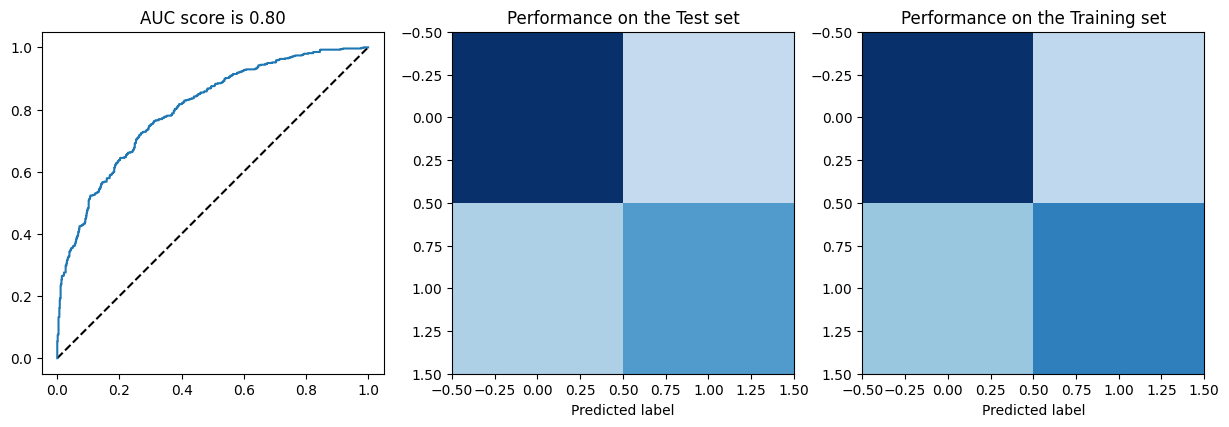

Random Forest Accuracy: 0.6661


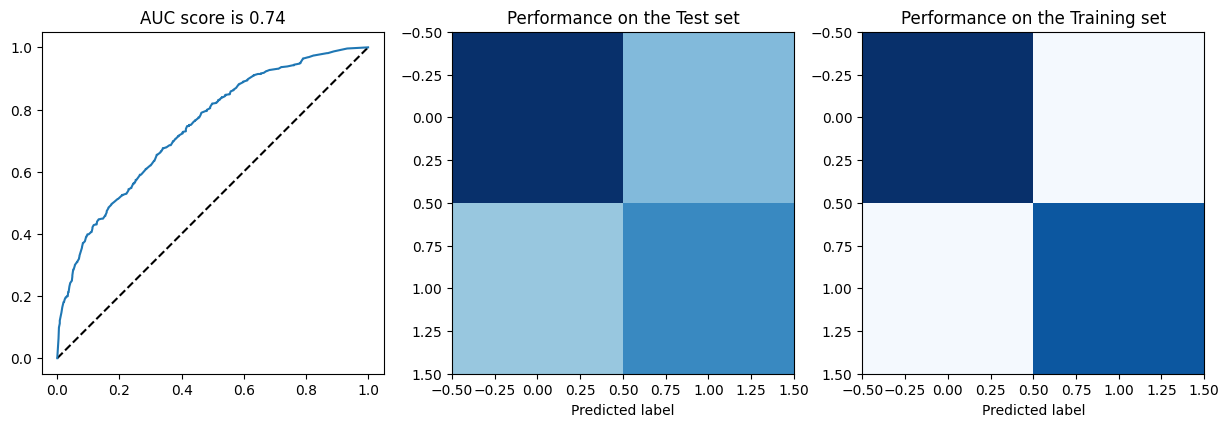

Gradient Boosting Accuracy: 0.7185


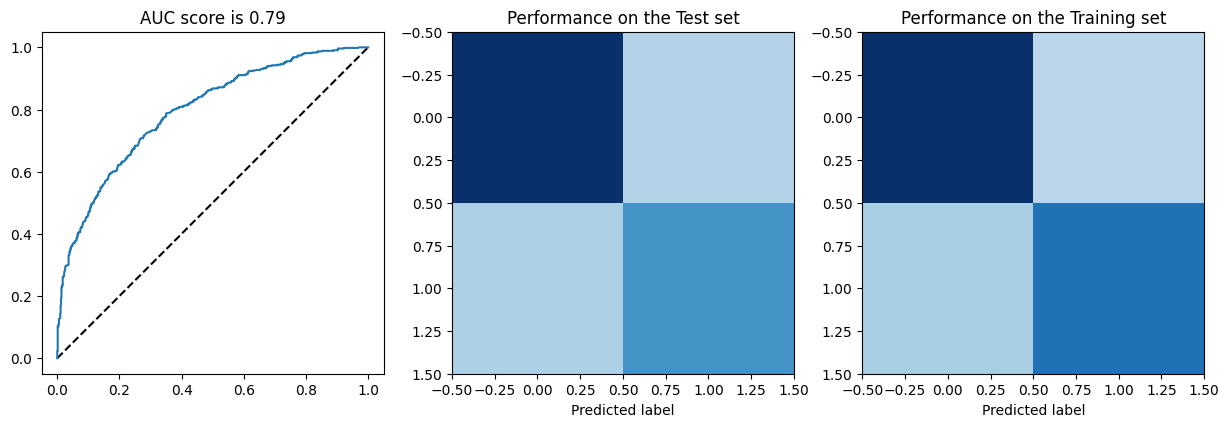

K-Nearest Neighbors Accuracy: 0.6802


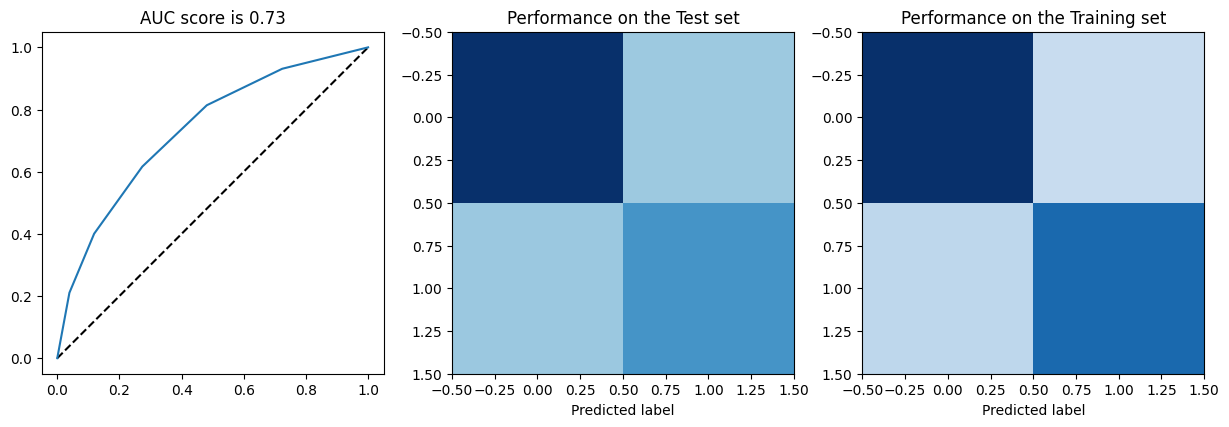

Neural Network Accuracy: 0.7045


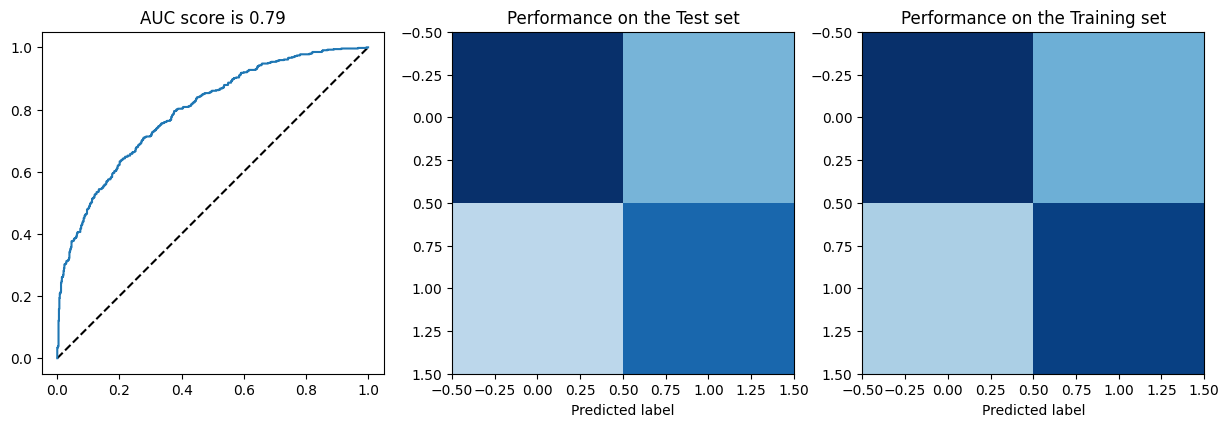

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
# Define a function to plot ROC curve and confusion matrix
def plot_evaluation(model, X_test, y_test):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(15, 5))

    # Plot ROC curve
    ax = plt.subplot(1, 3, 1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title('AUC score is {0:0.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
    ax.set_aspect(1)

    # Plot confusion matrix on the test set
    ax = plt.subplot(1, 3, 2)
    cm = confusion_matrix(y_test, model.predict(X_test))
    ax.imshow(cm, cmap='Blues', clim=(0, cm.max()))
    ax.set_xlabel('Predicted label')
    ax.set_title('Performance on the Test set')

    # Plot confusion matrix on the training set
    ax = plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_train, model.predict(X_train))
    ax.imshow(cm, cmap='Blues', clim=(0, cm.max()))
    ax.set_xlabel('Predicted label')
    ax.set_title('Performance on the Training set')

    plt.show()

# Evaluate models
models = {'Logistic Regression': logreg, 'Random Forest': rf, 'Gradient Boosting': gb,
           'K-Nearest Neighbors': knn, 'Neural Network': mlp}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.4f}')

    # Plot ROC curve and confusion matrix
    plot_evaluation(model, X_test, y_test)

Stakes distribution in the wrong predictions
is_stake
True     0.638889
False    0.361111
Name: count, dtype: float64
Stakes distribution overall
is_stake
True     0.689348
False    0.310652
Name: count, dtype: float64


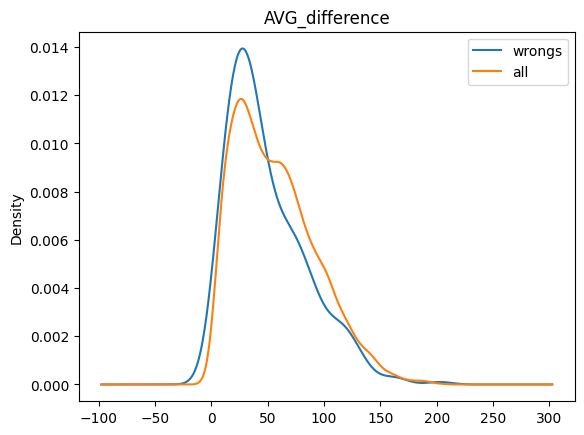

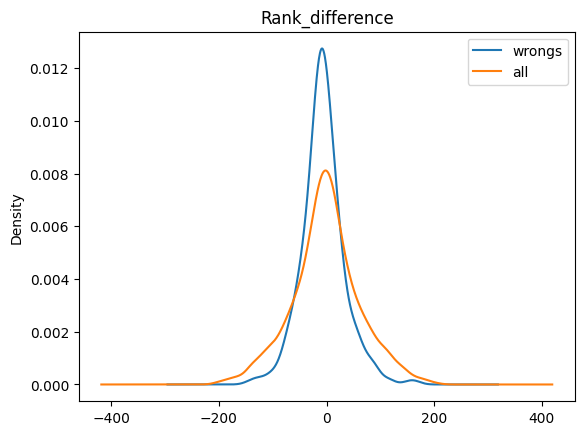

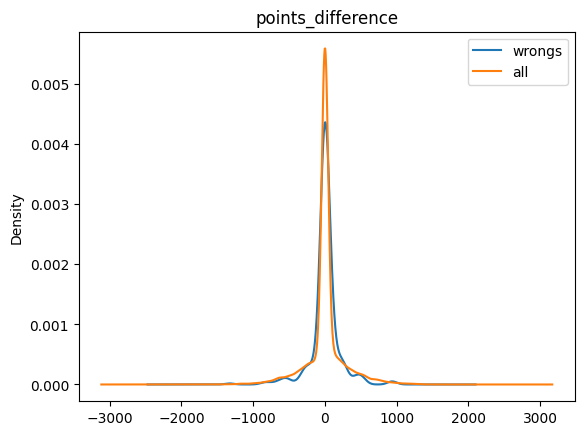

In [32]:
features = ['AVG_difference', 'Rank_difference', 'points_difference']
wrongs = y_test != gb.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])

print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [33]:
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
          "min_samples_split": [5, 10],
          "min_samples_leaf": [3, 5],
          "max_depth": [3, 5, 10],
          "max_features": ["sqrt"],
          "n_estimators": [100, 200]
          }

gb_cv = GridSearchCV(gb, params, cv=3, n_jobs=-1, verbose=True)
gb_cv.fit(X_train, y_train)

y_preds = gb_cv.predict(X_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


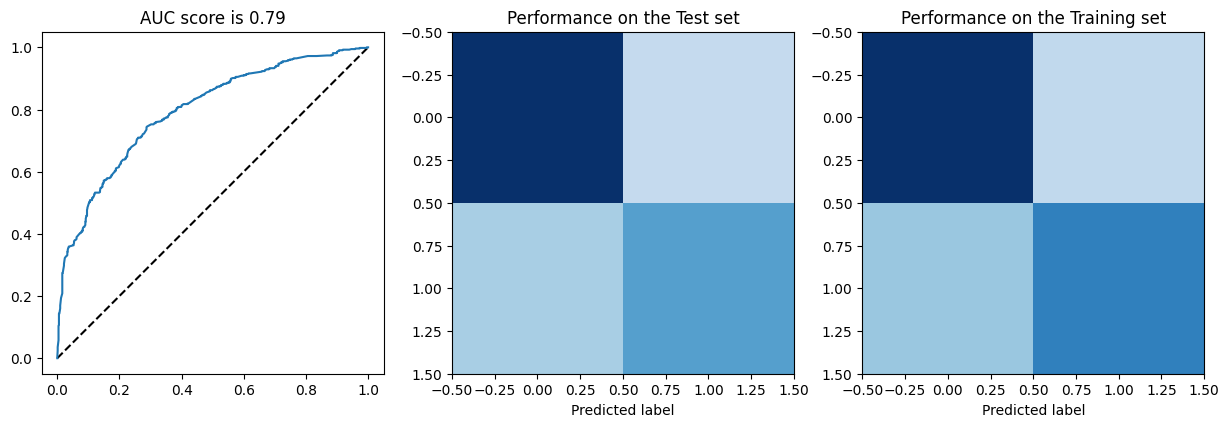

In [64]:
plot_evaluation(gb_cv,X_test,y_test)

In [62]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, random_state=42)

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rf_cv = GridSearchCV(rf, params, cv=3, n_jobs=-1, verbose=True)
rf_cv.fit(X_train, y_train)

y_preds = rf_cv.predict(X_test)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\tomte\anaconda3\envs\datavers\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
38 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tomte\anaconda3\envs\datavers\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tomte\anaconda3\envs\datavers\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\tomte\anaconda3\envs\datavers\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constra

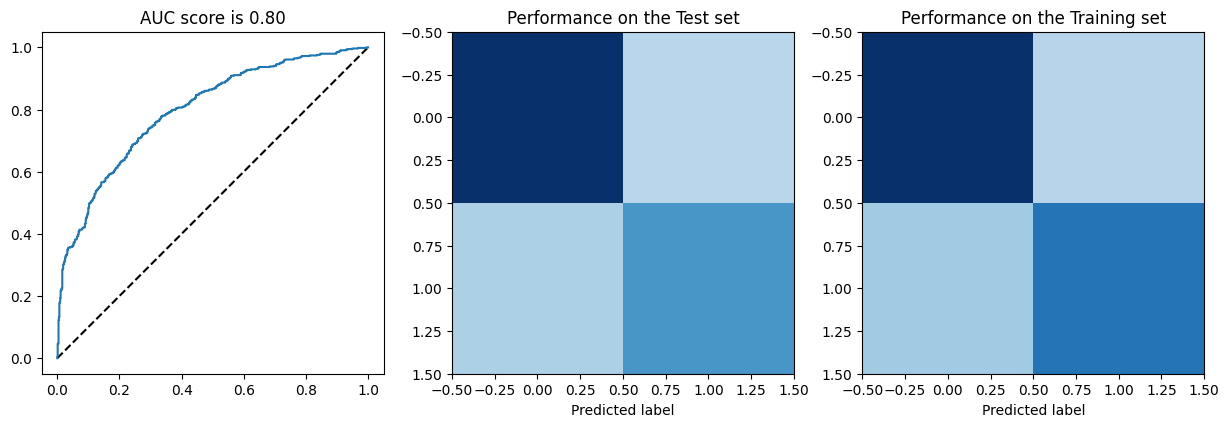

In [65]:
plot_evaluation(rf_cv,X_test,y_test)

In [108]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(objective= 'binary:logistic',
    nthread=4,
    seed=42
    )

params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_cv = GridSearchCV(xgb, params, cv=3, n_jobs=-1, verbose=True)
xgb_cv.fit(X_train, y_train)

y_preds = xgb_cv.predict(X_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


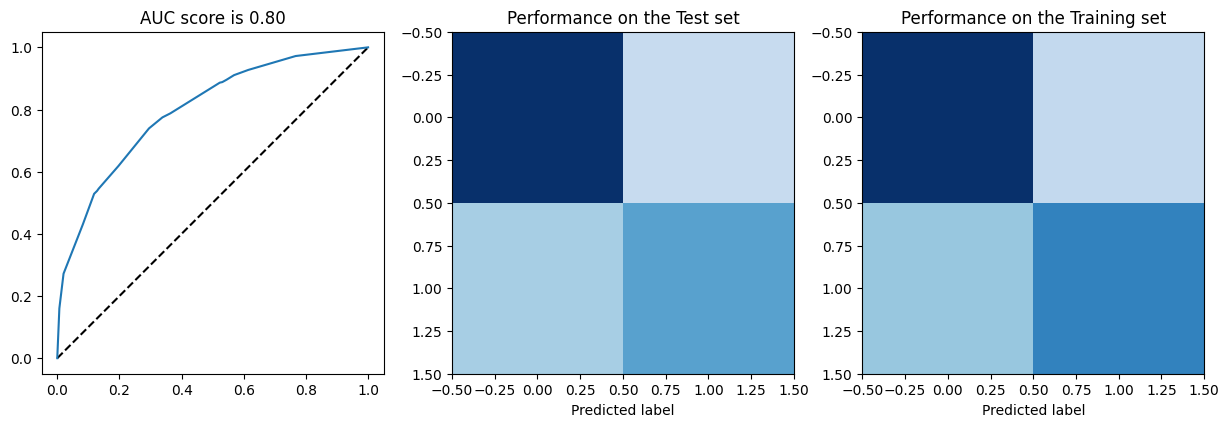

In [109]:
plot_evaluation(xgb_cv, X_test, y_test)

### Filter for Euro Teams

In [37]:
margin = 0.05

world_ranking = ranking_data.loc[
    (ranking_data['rank_date'] == ranking_data['rank_date'].max()) ]
world_ranking = world_ranking.replace({"Türkiye":"Turkey","Czechia": "Czech Republic"})
world_ranking = world_ranking.set_index(['country_full'])

In [38]:
world_ranking['win_probabilty'] = 0.0
world_ranking['tot_points'] = 0

In [39]:
world_ranking.columns.values[0] = "country_full"

In [36]:
euro_df = pd.read_csv('europe_groups.csv')

In [40]:
teamgroup = euro_df[['Group', 'HomeTeam']].drop_duplicates().reset_index(drop=True)
teamgroup['total_points'] = 0
teamgroup['win_prob'] = 0
teamgroup.set_index('HomeTeam', inplace=True)

In [42]:
#team_stats = world_ranking.merge(euro_df, how='left', left_on='country_full', right_on='HomeTeam')

In [ ]:
team_stats.insert(0, "country_fulls", team_stats['HomeTeam'])
team_stats.drop_duplicates(subset=['country_fulls'], inplace=True)

### Predicting First matches 

In [49]:
pd.DataFrame([{'Test':1, 'Test2': 2}, {'Test':1, 'Test2': 2}])

,Test,Test2
0,1,2
1,1,2


In [110]:
def predict_result(model, euro_df, world_ranking, teamgroup):

    opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']
    
    list_result = []
    
    for group in sorted(set(euro_df['Group'])):
        #print("\n-------Starting group {}-------  \n".format(group))
        group_matches = euro_df[euro_df['Group'] == group]
        for idx, row in group_matches.iterrows():
            dict_rows = {}
            dict_rows['group'] = group
            home = row["HomeTeam"]
            away = row["AwayTeam"]
            #print(f"{home} VS {away} --- \t", end="")
        
            # Creating a row for prediction
            row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        
            # Getting rank and points information
            home_rank = world_ranking.loc[home, 'rank']
            home_points = world_ranking.loc[home, 'total_points']
            opp_rank = world_ranking.loc[away, 'rank']
            opp_points = world_ranking.loc[away, 'total_points']
        
            # Adding features to the row
            row['AVG_difference'] = (home_rank + opp_rank) / 2
            row['Rank_difference'] = home_rank - opp_rank
            row['points_difference'] = home_points - opp_points
        
            # Predicting probabilities with the model
            home_win_prob1 = model.predict_proba(row)[:, 1][0]
        
            # Updating win probability and points in world_ranking DataFrame
            teamgroup.loc[home, 'win_prob'] += home_win_prob1
            teamgroup.loc[away, 'win_prob'] += 1 - home_win_prob1
    
            dict_rows['home'] = home
            dict_rows['away'] = away
            
            # Determining match outcome and updating points accordingly
            margin = 0.05
            if home_win_prob1 <= 0.5 - margin:
                #print(f"{away} Wins with {1 - home_win_prob1:.2f}")
                teamgroup.loc[away, 'total_points'] += 3
                dict_rows['winner'] = away
                dict_rows['prob'] = 1 - home_win_prob1
            elif home_win_prob1 >= 0.5 + margin:
                #print(f"{home} Wins with {home_win_prob1:.2f}")
                teamgroup.loc[home, 'total_points'] += 3
                dict_rows['winner'] = home
                dict_rows['prob'] = home_win_prob1
            else:
                #print(f"{home} and {away} DRAWS!! {home_win_prob1:.2f}% to win for {home} & {1-home_win_prob1:.2f}% to win for {away}")
                teamgroup.loc[home, 'total_points'] += 1
                teamgroup.loc[away, 'total_points'] += 1
                if home_win_prob1 > 0.5:
                    dict_rows['winner'] = home
                    dict_rows['prob'] = home_win_prob1
                else: 
                    dict_rows['winner'] = away
                    dict_rows['prob'] = 1 - home_win_prob1
    
            list_result.append(dict_rows)
    return pd.DataFrame(list_result)

### Result for Gradient Boosting Classifier

In [89]:
gradient_boosting_result = predict_result(gb_cv, euro_df, world_ranking, teamgroup)

### Result Random Forest 

In [90]:
random_forest_result = predict_result(rf_cv, euro_df, world_ranking, teamgroup)

### XGBoost Classifier

In [112]:
xgboost_result = predict_result(xgb_cv, euro_df, world_ranking, teamgroup)

## Check result per Pool

In [93]:
def print_result_pool(dataframe, group):
    return dataframe[dataframe['group'] == group]

### Pool A 

In [94]:
print_result_pool(gradient_boosting_result, 'A')

,group,home,away,winner,prob
0,A,Germany,Scotland,Germany,0.518019
1,A,Hungary,Switzerland,Switzerland,0.665267
2,A,Germany,Hungary,Germany,0.517003
3,A,Scotland,Switzerland,Switzerland,0.666793
4,A,Switzerland,Germany,Germany,0.521916
5,A,Scotland,Hungary,Hungary,0.539098


In [95]:
print_result_pool(random_forest_result, 'A')

,group,home,away,winner,prob
0,A,Germany,Scotland,Germany,0.552696
1,A,Hungary,Switzerland,Switzerland,0.744159
2,A,Germany,Hungary,Germany,0.573460
3,A,Scotland,Switzerland,Switzerland,0.741961
4,A,Switzerland,Germany,Germany,0.534731
5,A,Scotland,Hungary,Hungary,0.541171


In [113]:
print_result_pool(xgboost_result, 'A')

,group,home,away,winner,prob
0,A,Germany,Scotland,Germany,0.525357
1,A,Hungary,Switzerland,Switzerland,0.617895
2,A,Germany,Hungary,Germany,0.525357
3,A,Scotland,Switzerland,Switzerland,0.617895
4,A,Switzerland,Germany,Germany,0.525780
5,A,Scotland,Hungary,Hungary,0.525780


### Pool B 

In [96]:
print_result_pool(gradient_boosting_result, 'B')

,group,home,away,winner,prob
6,B,Spain,Croatia,Croatia,0.618532
7,B,Italy,Albania,Italy,0.612895
8,B,Croatia,Albania,Croatia,0.612895
9,B,Spain,Italy,Italy,0.593970
10,B,Albania,Spain,Spain,0.739926
11,B,Croatia,Italy,Italy,0.530757


In [97]:
print_result_pool(random_forest_result, 'B')

,group,home,away,winner,prob
6,B,Spain,Croatia,Croatia,0.665694
7,B,Italy,Albania,Italy,0.710024
8,B,Croatia,Albania,Croatia,0.707281
9,B,Spain,Italy,Italy,0.624520
10,B,Albania,Spain,Spain,0.868032
11,B,Croatia,Italy,Italy,0.555519


In [115]:
print_result_pool(xgboost_result, 'B')

,group,home,away,winner,prob
6,B,Spain,Croatia,Croatia,0.597288
7,B,Italy,Albania,Italy,0.634617
8,B,Croatia,Albania,Croatia,0.634617
9,B,Spain,Italy,Italy,0.567949
10,B,Albania,Spain,Spain,0.712358
11,B,Croatia,Italy,Italy,0.525780


### Pool C 

In [100]:
print_result_pool(gradient_boosting_result, 'C')

,group,home,away,winner,prob
12,C,Slovenia,Denmark,Denmark,0.703753
13,C,Serbia,England,England,0.673652
14,C,Slovenia,Serbia,Serbia,0.678707
15,C,Denmark,England,England,0.656255
16,C,England,Slovenia,England,0.612895
17,C,Denmark,Serbia,Serbia,0.529853


In [101]:
print_result_pool(random_forest_result, 'C')

,group,home,away,winner,prob
12,C,Slovenia,Denmark,Denmark,0.791612
13,C,Serbia,England,England,0.752014
14,C,Slovenia,Serbia,Serbia,0.776036
15,C,Denmark,England,England,0.734044
16,C,England,Slovenia,England,0.708835
17,C,Denmark,Serbia,Serbia,0.521051


In [116]:
print_result_pool(xgboost_result, 'C')

,group,home,away,winner,prob
12,C,Slovenia,Denmark,Denmark,0.712358
13,C,Serbia,England,England,0.617895
14,C,Slovenia,Serbia,Serbia,0.666665
15,C,Denmark,England,England,0.617895
16,C,England,Slovenia,England,0.634617
17,C,Denmark,Serbia,Serbia,0.525780


### Pool D 

In [99]:
print_result_pool(gradient_boosting_result, 'D')

,group,home,away,winner,prob
18,D,Poland,Netherlands,Netherlands,0.656255
19,D,Austria,France,France,0.687738
20,D,Poland,Austria,Austria,0.534880
21,D,Netherlands,France,France,0.616512
22,D,Netherlands,Austria,Netherlands,0.531870
23,D,France,Poland,France,0.548930


In [ ]:
print_result_pool(random_forest_result, 'D')

In [117]:
print_result_pool(xgboost_result, 'D')

,group,home,away,winner,prob
18,D,Poland,Netherlands,Netherlands,0.617895
19,D,Austria,France,France,0.657054
20,D,Poland,Austria,Austria,0.525780
21,D,Netherlands,France,France,0.597288
22,D,Netherlands,Austria,Netherlands,0.525357
23,D,France,Poland,France,0.538141


### Pool E 

In [ ]:
print_result_pool(gradient_boosting_result, 'E')

In [98]:
print_result_pool(random_forest_result, 'E')

,group,home,away,winner,prob
24,E,Romania,Ukraine,Ukraine,0.706597
25,E,Belgium,Slovakia,Belgium,0.710970
26,E,Slovakia,Ukraine,Ukraine,0.699574
27,E,Belgium,Romania,Belgium,0.710970
28,E,Slovakia,Romania,Romania,0.540119
29,E,Ukraine,Belgium,Belgium,0.751052


In [118]:
print_result_pool(xgboost_result, 'E')

,group,home,away,winner,prob
24,E,Romania,Ukraine,Ukraine,0.619286
25,E,Belgium,Slovakia,Belgium,0.634617
26,E,Slovakia,Ukraine,Ukraine,0.617895
27,E,Belgium,Romania,Belgium,0.634617
28,E,Slovakia,Romania,Romania,0.567949
29,E,Ukraine,Belgium,Belgium,0.617895


### Pool F 

In [119]:
print_result_pool(gradient_boosting_result, 'F')

,group,home,away,winner,prob
30,F,Turkey,Georgia,Turkey,0.593396
31,F,Portugal,Czech Republic,Portugal,0.576568
32,F,Georgia,Czech Republic,Czech Republic,0.704368
33,F,Turkey,Portugal,Portugal,0.680468
34,F,Georgia,Portugal,Portugal,0.746068
35,F,Czech Republic,Turkey,Turkey,0.531656


In [120]:
print_result_pool(random_forest_result, 'F')

,group,home,away,winner,prob
30,F,Turkey,Georgia,Turkey,0.693087
31,F,Portugal,Czech Republic,Portugal,0.662767
32,F,Georgia,Czech Republic,Czech Republic,0.783585
33,F,Turkey,Portugal,Portugal,0.776420
34,F,Georgia,Portugal,Portugal,0.890458
35,F,Czech Republic,Turkey,Turkey,0.503784


In [121]:
print_result_pool(xgboost_result, 'F')

,group,home,away,winner,prob
30,F,Turkey,Georgia,Turkey,0.570160
31,F,Portugal,Czech Republic,Portugal,0.570160
32,F,Georgia,Czech Republic,Czech Republic,0.712358
33,F,Turkey,Portugal,Portugal,0.666665
34,F,Georgia,Portugal,Portugal,0.767294
35,F,Czech Republic,Turkey,Turkey,0.525780
